# Physics-informed kernel regression

We start by defining the kernel $K(x, y) = \frac{\gamma_n}{2\lambda_n \sinh(2\gamma_n L)}( (\cosh(2\gamma_n L)+\cosh(2\gamma_n x))\cosh(\gamma_n (x-y))+ ((1-2 \times 1_{x >y})\sinh(2\gamma_n L) - \sinh(2 \gamma_n x)) \sinh(\gamma_n(x-y)))$ in the kernel_matrix function.

In [ ]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge

def order_function_mat(mat_x,mat_x_t):
    return  np.where(mat_x > mat_x_t, 1, 0)

def kernel_matrix(mat_x,mat_z, lambda_n, mu_n, L):
    gamma = np.sqrt(lambda_n/(lambda_n+mu_n))

    return gamma/(2*lambda_n*np.sinh(2*gamma*L))*(np.multiply((np.cosh(2*gamma*L)+np.cosh(2*gamma*mat_x)),np.cosh(gamma*(mat_x-mat_z)))+
        np.multiply(((1-2*order_function_mat(mat_x,mat_z))*np.sinh(2*gamma*L)-np.sinh(2*gamma*mat_x)),np.sinh(gamma*(mat_x-mat_z))))


Then, we visualize the kernel on $[-1,1]^2$ with $\lambda_n = \mu_n = 1$.

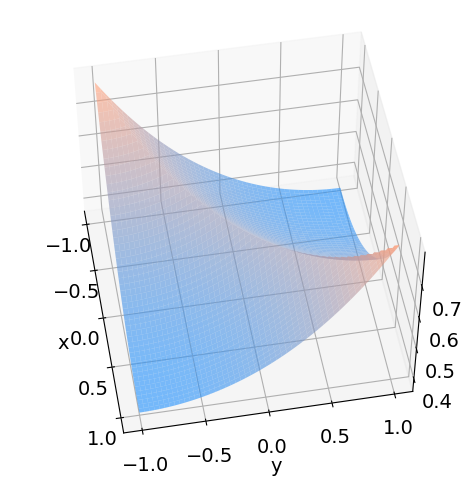

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors

lambda_n, mu_n = 1,1
mat_x, mat_y = np.meshgrid(np.linspace(-1, 1, 1000), np.linspace(-1, 1, 1000))
kn=kernel_matrix(mat_x, mat_y, lambda_n, mu_n ,1)

font = {'family' : 'sans-serif',
        'size'   : 20}
plt.rc('font', **font)

fig = plt.figure(figsize=(10,10)) #plt.figaspect(0.5)

 # Plotting the overfitting network
ax = fig.add_subplot(1,2,1, projection='3d')
ax.tick_params(axis='both', which='major', labelsize=14)
cmap = colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "lightsalmon"])
surf = ax.plot_surface(mat_x, mat_y, kn, cmap=cmap, linewidth=0, alpha=0.6)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
ax.view_init(50, -10)
plt.tight_layout()
#ig.colorbar(surf, shrink=0.9, aspect=5)
plt.savefig("kernel2d.pdf",bbox_inches='tight',pad_inches=0)
plt.show()

# 1. Perfect modeling

In [ ]:
L = 1
sigma = 0.3

Here, the reader can set $n$ and the hyperparameters $\lambda_n$ and $\mu_n$ to the value they want.

In [ ]:
n = 100
lambda_n, mu_n = np.log(n)/n, 1/np.log(n)

For reproducibility purposes, we specify a seed when generating the data. In this perfect modeling scenario,
* $\Omega = [-1,1]$,
* $Y = u^\star(X) + \varepsilon$, where $u^\star(x) = 1$, and
* $\frac{d}{dx} u^\star = 0$.


In [ ]:
np.random.seed(seed=3016)

data_x = np.random.uniform(-L,L,n)
data_y = 1+ np.random.normal(0,sigma, n)

Then, we compute the kernel matrix $kn$ such that $kn_{i,j} = K(x_i, x_j)$ and we fit the kernel estimator associated with $K$.

In [ ]:
mat_x = np.tile(data_x, (n, 1))
kn=kernel_matrix(mat_x, mat_x.transpose(), lambda_n,mu_n,L)


krr = KernelRidge(alpha=n, kernel = 'precomputed')
krr.fit(kn, data_y)

KernelRidge(alpha=100, kernel='precomputed')

We sample $m = 500$ test points to estimate the error of the estimator.



In [ ]:
np.random.seed(seed=3016)

m=500
z = np.random.uniform(-L,L,m)
ground_truth = 1

mat_xz = np.tile(data_x, (len(z), 1 ))
mat_z = np.tile(z, (len(data_x), 1 )).transpose()
kz = kernel_matrix(mat_xz,mat_z, lambda_n, mu_n, L)
estimator = krr.predict(kz)

print("L'erreur l^2 dans le cas de modélisation parfaite pour n=" + str(n)+" est ")
print(sum(np.square(estimator - ground_truth))/m)

L'erreur l^2 dans le cas de modélisation parfaite pour n=100 est 
0.006945643240129996


We plot the training samples in blue and the estimator in orange. Recall that the ground truth is $Y = 1$.

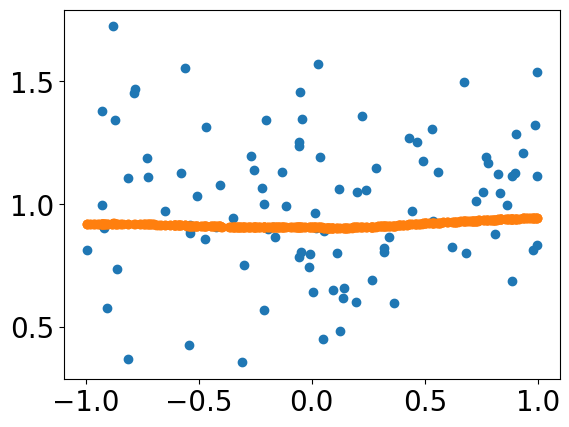

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data_x, data_y)
plt.scatter(z, estimator)
plt.show()

#2. Imperfect modeling

In this imperfect modeling scenario,
* $\Omega = [-1,1]$,
* $Y = u^\star(X) + \varepsilon$, where $u^\star(x) = 1 + \frac{|x|}{2}$, and
* $\|\frac{d}{dx} u^\star\|_{L^2([-1,1])} = \frac{1}{2}$.

In [ ]:
np.random.seed(seed=3016)

data_x = np.random.uniform(-L,L,n)
data_y = 1 + 0.5*np.abs(data_x)+ np.random.normal(0,sigma, n)

We rely on a different scaling of the hyperparameters: $\lambda_n = \frac{\ln(n)}{n}$ and $\mu_n = n^{-2/3}$.

In [ ]:
lambda_n, mu_n =  np.log(n)/n, 2*n**(-2/3)

Then, we compute the kernel matrix $kn$ and we fit the kernel estimator.

In [ ]:
mat_x = np.tile(data_x, (n, 1))
kn=kernel_matrix(mat_x, mat_x.transpose(), lambda_n,mu_n,L)
krr = KernelRidge(alpha=n, kernel = 'precomputed')
krr.fit(kn, data_y)

KernelRidge(alpha=100, kernel='precomputed')

We sample $m = 500$ test points to estimate the error of the estimator.

In [ ]:
np.random.seed(seed=3016)

z = np.random.uniform(-L,L,m)
ground_truth = 1+0.5*np.abs(z)

mat_xz = np.tile(data_x, (len(z), 1 ))
mat_z = np.tile(z, (len(data_x), 1 )).transpose()
kz = kernel_matrix(mat_xz,mat_z, lambda_n, mu_n, L)
estimator = krr.predict(kz)

print("L'erreur l^2 dans le cas de modélisation imparfaite pour n=" + str(n)+" est ")
print(sum(np.square(estimator - ground_truth))/m)

L'erreur l^2 dans le cas de modélisation imparfaite pour n=100 est 
0.018971307656082993


We plot the training samples in blue, the estimator in orange, and the ground truth in green. Recall that the ground truth is $Y = 1 + |X|$.

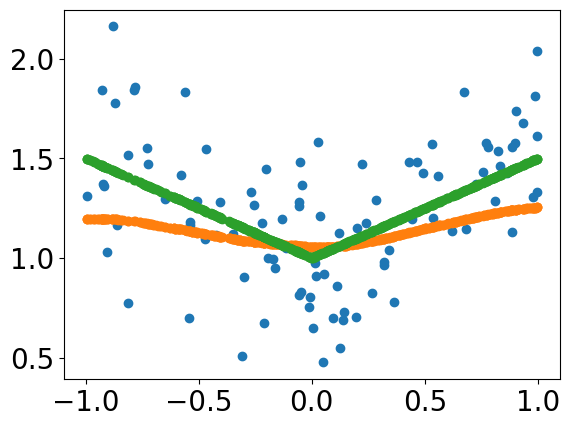

In [ ]:
plt.scatter(data_x, data_y)
plt.scatter(z, estimator)
plt.scatter(z, ground_truth)
plt.show()

# 3. Dependency of the error in function of n

## Perfect modeling

We run the same code as before for different values of $n$.

In [ ]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge

def order_function_mat(mat_x,mat_x_t):
    return  np.where(mat_x > mat_x_t, 1, 0)

def kernel_matrix(mat_x,mat_z, lambda_n, mu_n, L):
    gamma = np.sqrt(lambda_n/(lambda_n+mu_n))

    return gamma/(2*lambda_n*np.sinh(2*gamma*L))*(np.multiply((np.cosh(2*gamma*L)+np.cosh(2*gamma*mat_x)),np.cosh(gamma*(mat_x-mat_z)))+
        np.multiply(((1-2*order_function_mat(mat_x,mat_z))*np.sinh(2*gamma*L)-np.sinh(2*gamma*mat_x)),np.sinh(gamma*(mat_x-mat_z))))


L = 1
sigma = 1
m=500

np.random.seed(seed=31)
samples = []
err_parf = []


for exponent in range(6, 25):
  n = int(10**(exponent/6))
  lambda_n, mu_n = np.log(n)/n, 1/np.log(n)

  err_n = []
  for sample in range(10):
    data_x = np.random.uniform(-L,L,n)
    data_y = 1+ np.random.normal(0,sigma, n)

    mat_x = np.tile(data_x, (n, 1))
    kn=kernel_matrix(mat_x, mat_x.transpose(), lambda_n,mu_n,L)

    krr = KernelRidge(alpha=n, kernel = 'precomputed')
    krr.fit(kn, data_y)

    z = np.random.uniform(-L,L,m)
    ground_truth = 1

    mat_xz = np.tile(data_x, (len(z), 1 ))
    mat_z = np.tile(z, (len(data_x), 1 )).transpose()
    kz = kernel_matrix(mat_xz, mat_z, lambda_n, mu_n, L)
    estimator = krr.predict(kz)

    err_n.append(sum(np.square(estimator - ground_truth))/m)
  err_parf.append(err_n)
  samples.append(n)
  print("Step "+str(exponent)+", corresponding to n="+ str(n)+", is done.")

Step 6, corresponding to n=10, is done.
Step 7, corresponding to n=14, is done.
Step 8, corresponding to n=21, is done.
Step 9, corresponding to n=31, is done.
Step 10, corresponding to n=46, is done.
Step 11, corresponding to n=68, is done.
Step 12, corresponding to n=100, is done.
Step 13, corresponding to n=146, is done.
Step 14, corresponding to n=215, is done.
Step 15, corresponding to n=316, is done.
Step 16, corresponding to n=464, is done.
Step 17, corresponding to n=681, is done.
Step 18, corresponding to n=1000, is done.
Step 19, corresponding to n=1467, is done.
Step 20, corresponding to n=2154, is done.
Step 21, corresponding to n=3162, is done.
Step 22, corresponding to n=4641, is done.
Step 23, corresponding to n=6812, is done.
Step 24, corresponding to n=10000, is done.


We estimate the convergence rate $\alpha$ such that $err(n) = \Theta_n(n^\alpha)$, or similarly $\ln(err)(n) \sim \alpha \ln(n) + \beta$ using a linear regression.

<ipython-input-17-9365e9044f7b>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


alpha = -1.017748375615096




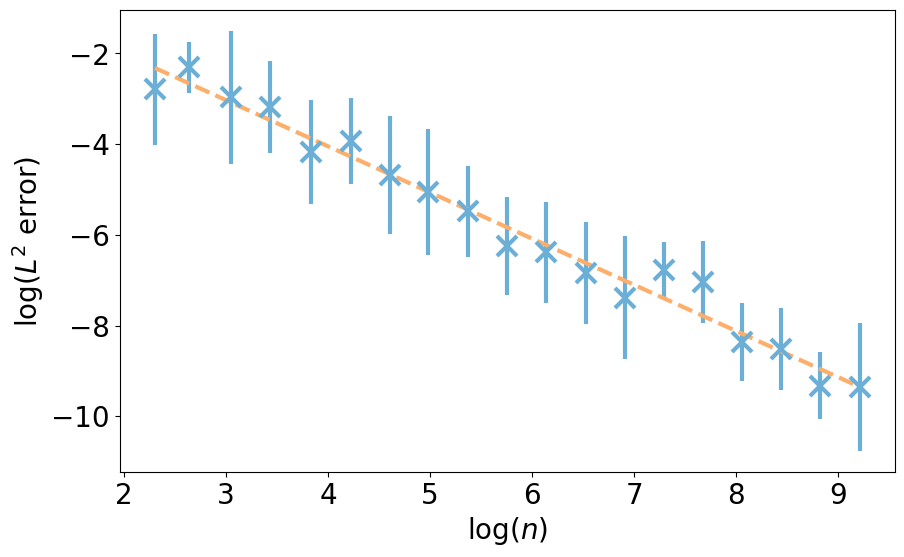

In [ ]:
import matplotlib.pyplot as plt


from matplotlib import cm
from matplotlib import colors

samples = []
for exponent in range(6, 25):
  n = int(10**(exponent/6))
  samples.append(n)

# Font management
font = {'family' : 'sans-serif',
        'size'   : 20}
plt.rc('font', **font)
plt.figure(figsize=(10,6))
cmap = cm.get_cmap('tab20c')


y1_color = cmap(1/20) #bleu
y2_color = cmap(6/20) #orange
y3_color = cmap(9/20) #vert

err_mean = [np.mean(np.log(err_sample)) for err_sample in err_parf]
err_std = [np.std(np.log(err_sample)) for err_sample in err_parf]

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(np.log(samples).reshape(-1,1), err_mean)
print("alpha = " + str(reg.coef_[0])+'\n\n')


plt.errorbar(np.log(samples), err_mean, err_std, linestyle='None', marker='x',linewidth=3, color=y1_color, markersize=14,mew=3)

x = np.linspace(np.log(samples[0]), np.log(samples[-1]), 1000)
plt.plot(x, reg.coef_[0]*x + reg.intercept_, linestyle='--', linewidth=3, color=y2_color)
plt.xlabel("$\log(n)$")
plt.ylabel("$\log(L^2$ error)")
plt.savefig("perfect.pdf")
plt.show()

## Imperfect modeling

In [ ]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge

def order_function_mat(mat_x,mat_x_t):
    return  np.where(mat_x > mat_x_t, 1, 0)

def kernel_matrix(mat_x,mat_z, lambda_n, mu_n, L):
    gamma = np.sqrt(lambda_n/(lambda_n+mu_n))

    return gamma/(2*lambda_n*np.sinh(2*gamma*L))*(np.multiply((np.cosh(2*gamma*L)+np.cosh(2*gamma*mat_x)),np.cosh(gamma*(mat_x-mat_z)))+
        np.multiply(((1-2*order_function_mat(mat_x,mat_z))*np.sinh(2*gamma*L)-np.sinh(2*gamma*mat_x)),np.sinh(gamma*(mat_x-mat_z))))


L = 1
sigma = 1
m=500

np.random.seed(seed=31)
samples = []
err_imparf = []


for exponent in range(6, 25):
  n = int(10**(exponent/6))
  lambda_n, mu_n =  np.log(n)/n, n**(-2/3)

  err_n = []
  for sample in range(10):
    data_x = np.random.uniform(-L,L,n)
    data_y = 1+ 0.1*np.abs(data_x)+np.random.normal(0,sigma, n)

    mat_x = np.tile(data_x, (n, 1))
    kn=kernel_matrix(mat_x, mat_x.transpose(), lambda_n,mu_n,L)

    krr = KernelRidge(alpha=n, kernel = 'precomputed')
    krr.fit(kn, data_y)

    z = np.random.uniform(-L,L,m)
    ground_truth = 1 + 0.1*np.abs(z)

    mat_xz = np.tile(data_x, (len(z), 1 ))
    mat_z = np.tile(z, (len(data_x), 1 )).transpose()
    kz = kernel_matrix(mat_xz, mat_z, lambda_n, mu_n, L)
    estimator = krr.predict(kz)

    err_n.append(sum(np.square(estimator - ground_truth))/m)
  err_imparf.append(err_n)
  samples.append(n)
  print("Step "+str(exponent)+", corresponding to n="+ str(n)+", is done.")

Step 6, corresponding to n=10, is done.
Step 7, corresponding to n=14, is done.
Step 8, corresponding to n=21, is done.
Step 9, corresponding to n=31, is done.
Step 10, corresponding to n=46, is done.
Step 11, corresponding to n=68, is done.
Step 12, corresponding to n=100, is done.
Step 13, corresponding to n=146, is done.
Step 14, corresponding to n=215, is done.
Step 15, corresponding to n=316, is done.
Step 16, corresponding to n=464, is done.
Step 17, corresponding to n=681, is done.
Step 18, corresponding to n=1000, is done.
Step 19, corresponding to n=1467, is done.
Step 20, corresponding to n=2154, is done.
Step 21, corresponding to n=3162, is done.
Step 22, corresponding to n=4641, is done.
Step 23, corresponding to n=6812, is done.
Step 24, corresponding to n=10000, is done.


We estimate the convergence rate $\alpha$ such that $\ln(err)(n) = \alpha \ln(n) + \beta$ using a linear regression.

<ipython-input-21-177a625f4369>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


alpha = -0.7688542333951904




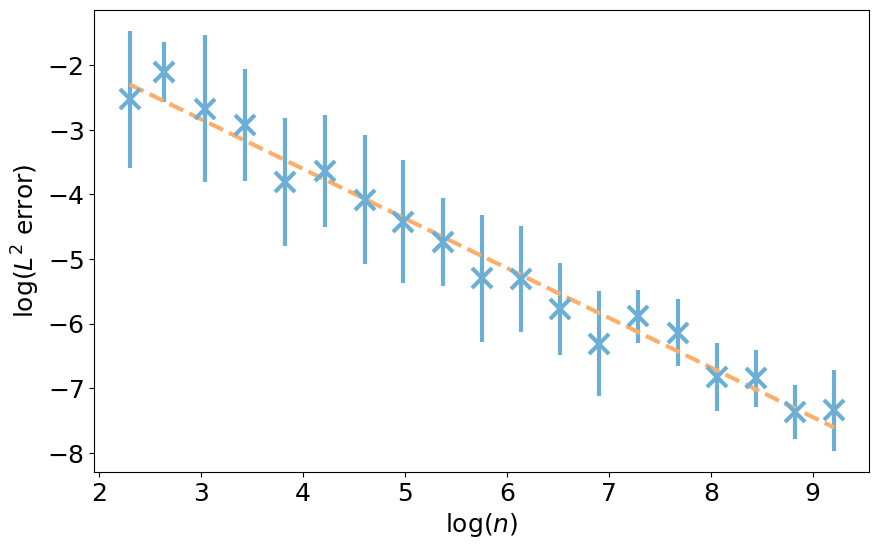

In [ ]:
import matplotlib.pyplot as plt


from matplotlib import cm
from matplotlib import colors

# Font management
font = {'family' : 'sans-serif',
        'size'   : 18}
plt.rc('font', **font)
plt.figure(figsize=(10,6))
cmap = cm.get_cmap('tab20c')


y1_color = cmap(1/20) #bleu
y2_color = cmap(6/20) #orange
y3_color = cmap(9/20) #vert

err_mean = [np.mean(np.log(err_sample)) for err_sample in err_imparf]
err_std = [np.std(np.log(err_sample)) for err_sample in err_imparf]

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(np.log(samples).reshape(-1,1), err_mean)
print("alpha = " + str(reg.coef_[0])+'\n\n')


plt.errorbar(np.log(samples), err_mean, err_std, linestyle='None', marker='x',linewidth=3, color=y1_color, markersize=14,mew=3)

x = np.linspace(np.log(samples[0]), np.log(samples[-1]), 1000)
plt.plot(x, reg.coef_[0]*x + reg.intercept_, linestyle='--', linewidth=3, color=y2_color)
plt.xlabel("$\log(n)$")
plt.ylabel("$\log(L^2$ error)")
plt.savefig("imperfect.pdf")
plt.show()